# Initial learning trials
functional: b3lypg

basis: sto-3g

In [18]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

train_test_seed = 42

source_path = '../../datasets/QM9/xyz_c5h4n2o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [19]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap

check if all files converged - if we have something to compare to!

In [93]:
focks = []
used_files = []
reference_densities = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
    reference_densities.append(ret[0].numpy)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


Now let's create the reference - use the overlap matrix - this is already needed for the first step so this is basically free! 

In [21]:
from scf_guess_tools import Backend, load
from pyscf.gto import Mole
import re, time
import matplotlib.pyplot as plt

overlaps = []
for file in used_files:
    lines = open(file).readlines()
    q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
    m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))
    start_ = time.time()
    mol = Mole(atom=file, charge=q, spin=m - 1, symmetry=True)
    mol.basis = 'sto-3g'
    mol.build()
    S = mol.intor('int1e_ovlp')
    overlaps.append(np.asarray(S))

Now we have our in & outputs but half of the matrix is irrelevant so we use the following utility functions

In [22]:
def flatten_triang(M): 
    return M[np.triu_indices(M.shape[0], k=0)]
def unflatten_triang(flat, N):
    M = np.zeros((N, N))
    iu = np.triu_indices(N)
    M[iu] = flat
    M[(iu[1], iu[0])] = flat  # Symmetrie
    return M

## Dataset split

In [23]:
train, test = train_test_split(
    list(zip(focks, overlaps, used_files)), 
    test_size=0.2, 
    random_state=train_test_seed
)

### Now Ridge Regression

In [24]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor

In [25]:
X = np.array([flatten_triang(overlap) for _, overlap, _ in train])
y = np.array([flatten_triang(fock) for fock, _ , _ in train])
base_model = RidgeCV(alphas=np.logspace(-1.5, 2.5, 5, base=10), cv=5)
model = MultiOutputRegressor(base_model)
start_ = time.time()
model.fit(X,y=y)
print(f"CV Training time: {time.time() - start_:.2f} seconds")
best_alphas = np.array([estimator.alpha_ for estimator in model.estimators_])
print(f"Best alphas: \nmean: {best_alphas.mean()}\nstd: {best_alphas.std()}\nmin: {best_alphas.min()}\nmax: {best_alphas.max()}")
base_model = Ridge(alpha=best_alphas.mean())
model = MultiOutputRegressor(base_model)

start_ = time.time()
model.fit(X, y=y)
print(f"Refit-Training time: {time.time() - start_:.2f} seconds")
# train error: 
train_pred = model.predict(X)
train_error = root_mean_squared_error(y, train_pred)
print(f"Train error: {train_error:.4f}")

# test error:
X_test = np.array([flatten_triang(overlap) for _ , overlap, _ in test])
y_test = np.array([flatten_triang(fock) for fock, _, _  in test])
test_pred = model.predict(X_test)
test_error = root_mean_squared_error(y_test, test_pred)
print(f"Test error: {test_error:.4f}")
sum_of_squares = np.mean(np.sum((np.zeros_like(y_test) - y_test)**2, axis=1))
print(f"Average sum of squares of y_test: {sum_of_squares:.4f}")

CV Training time: 102.07 seconds
Best alphas: 
mean: 5.663781269174882
std: 38.239596324243095
min: 0.03162277660168379
max: 316.22776601683796
Refit-Training time: 4.99 seconds
Train error: 0.0436
Test error: 0.0570
Average sum of squares of y_test: 1801.2192


ok sum of squares is really large compared to RMSE and RMSE between train and test is comparable but certainly not good -> I mean we have a small dataset only 508 samples!

In [ ]:
def plot_fock_comparison(ex_test, ex_pred, size, matrix_metric="Fock", title="Fock Matrix Comparison", vmax=1.5):
    diff = ex_test - ex_pred
    rmse = root_mean_squared_error(ex_test, ex_pred)
    
    test_mat = unflatten_triang(ex_test, size) if ex_test.shape[0] != size else ex_test
    pred_mat = unflatten_triang(ex_pred, size) if ex_pred.shape[0] != size else ex_pred
    diff_mat = unflatten_triang(diff, size) if diff.shape[0] != size else diff
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
    fig.suptitle(f"{title}  |  RMSE: {rmse:.4f}")
    
    ax[0].imshow(test_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[0].set_title(f"{matrix_metric} converged (REFERENCE)")
    
    ax[1].imshow(pred_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[1].set_title(f"{matrix_metric} from overlap (PREDICTION)")
    
    diff_plot = ax[2].imshow(diff_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[2].set_title("Difference")
    
    cbar = fig.colorbar(diff_plot, cax=ax[3])
    cbar.set_label("Difference Scale")
    
    plt.tight_layout()
    plt.show()

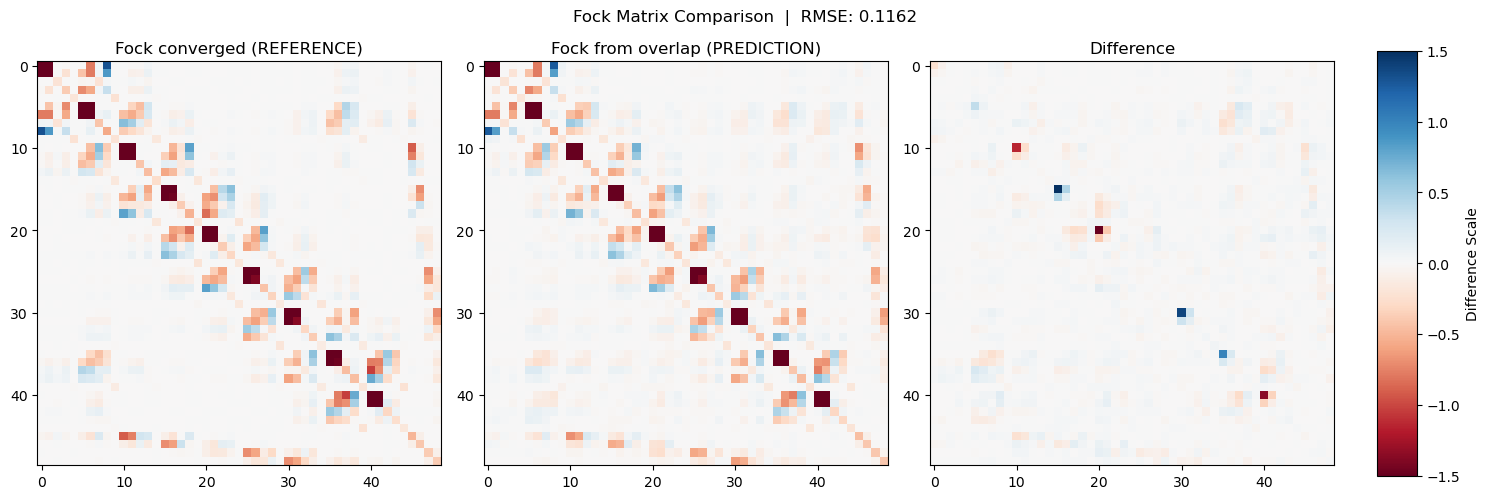

In [105]:
# let's checkout a example: 
random_test_sample = np.random.randint(0, len(X_test))
ex_test = y_test[random_test_sample]
ex_pred = test_pred[random_test_sample]

# diff = ex_test - ex_pred
# diff = unflatten_triang(diff, 49)
# rmse = root_mean_squared_error(ex_test, ex_pred)
# print(f"RMSE: {rmse:.4f}")
# fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
# fig.suptitle(f"RMSE: {rmse:.4f}")
# ax[0].imshow(unflatten_triang(ex_test, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[0].set_title("Fock converged (REFERENCE)")
# ax[1].imshow(unflatten_triang(ex_pred, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[1].set_title("Fock from overlap (PREDICTION)")
# diff_plot = ax[2].imshow(diff, cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[2].set_title("Difference")
# cbar = fig.colorbar(diff_plot, cax=ax[3])
# cbar.set_label("Difference Scale")
plot_fock_comparison(ex_test, ex_pred, 49, title="Fock Matrix Comparison", vmax=1.5)

# Check if convergence is faster! 

In [85]:
from scipy.linalg import eigh
def check_positive_definite(S, tol=1e-10):
    # Eigenwerte prüfen
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_pred(model, overlap, nocc): 
    assert check_positive_definite(overlap)
    fock = model.predict(flatten_triang(overlap).reshape(1, -1))
    fock = unflatten_triang(fock, overlap.shape[0])
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = C_occ @ C_occ.T
    return density

In [ ]:
from scf_guess_tools import Backend, guess, calculate, load
from pyscf import scf

def sim(file, overlap, use_pred=False): 
    backend = Backend.PY
    mol = load(file, backend)
    mol_native = mol.native
    mol_native.basis = "sto-3g"
    mol_native.build()

    if use_pred: 
        start_ = time.time()
        D_ = density_pred(model, overlap, mol_native.nelec[0]) # nocc per shell
        mf = scf.RKS(mol_native)
        mf.xc = "b3lypg"
        print(f"Pred time, {time.time() - start_}")
        mf.kernel(dm0=D_)
        wf = mf
        
    else: 
        wf = calculate(mol, basis="sto-3g", method="dft", functional="b3lypg", guess="minao", cache=False)
        wf = wf.native

    return {"cycles": wf.cycles, "conv": wf.converged, "summary": wf.scf_summary}


File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900963
{'cycles': 11, 'conv': True, 'summary': {'nuc': np.float64(433.8378878463838), 'e1': np.float64(-1469.2974787693572), 'coul': np.float64(648.125588863252), 'exc': np.float64(-59.612701841241574)}}
Pred time, 0.17918944358825684
converged SCF energy = -446.946703900746
{'cycles': 18, 'conv': True, 'summary': {'nuc': np.float64(433.8378878463838), 'e1': np.float64(-1469.2975161330987), 'coul': np.float64(648.1256288311066), 'exc': np.float64(-59.612704445137716)}}
Early stop: 9
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131581.xyz
converged SCF energy = -446.816879401014
{'cycles': 11, 'conv': True, 'summary': {'nuc': np.float64(380.1825821149959), 'e1': np.float64(-1362.7531050211514), 'coul': np.float64(595.2756971255453), 'exc': np.float64(-59.52205362040351)}}
Pred time, 0.2074143886566162
converged SCF energy = -446.816879400947
{'cycles': 19, 'conv': True, 'summary': {'nuc': np.

/tmp/ipykernel_940/785317164.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([reference_time, model_time], labels=["Reference", "Model"], patch_artist=True)


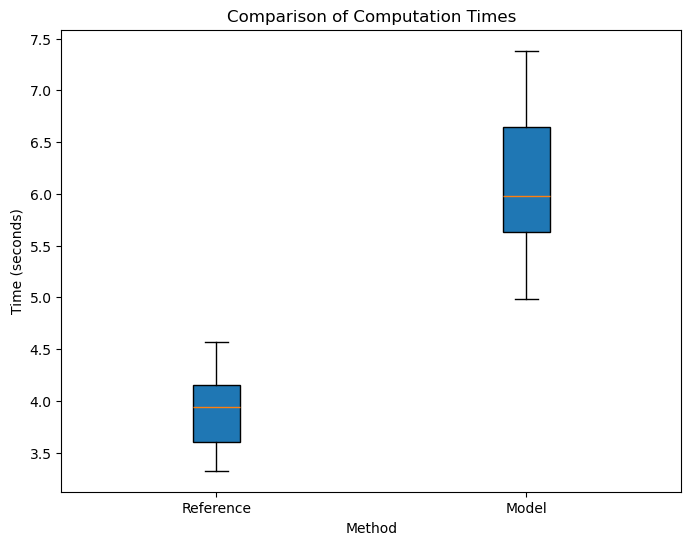

In [94]:
reference_time, model_time = [], []
early_stop = 10
for _, overlap, file in test: # benchmark on test data! 
    print(f"File: {file}")
    start_ = time.time()
    res = sim(file, overlap)
    print(res)
    end_ = time.time()
    # print(f"Reference time: {end_ - start_:.2f} seconds")
    reference_time.append(end_ - start_)
    start_ = time.time()
    res = sim(file, overlap, use_pred=True)
    print(res)
    end_ = time.time()
    # print(f"Guess time: {end_ - start_:.2f} seconds")
    model_time.append(end_ - start_)
    if early_stop < 0: 
        break
    early_stop -= 1

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([reference_time, model_time], labels=["Reference", "Model"], patch_artist=True)
ax.set_title("Comparison of Computation Times")
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Method")
plt.show()

Hmm funktioniert doch nicht einmal so gut

In [116]:
sample_file = used_files[0]
mol = load(sample_file, Backend.PY)
nr_elec = mol.native.nelec[0]
ref_density = reference_densities[0]
guess_density = density_pred(model, overlaps[0], nr_elec)

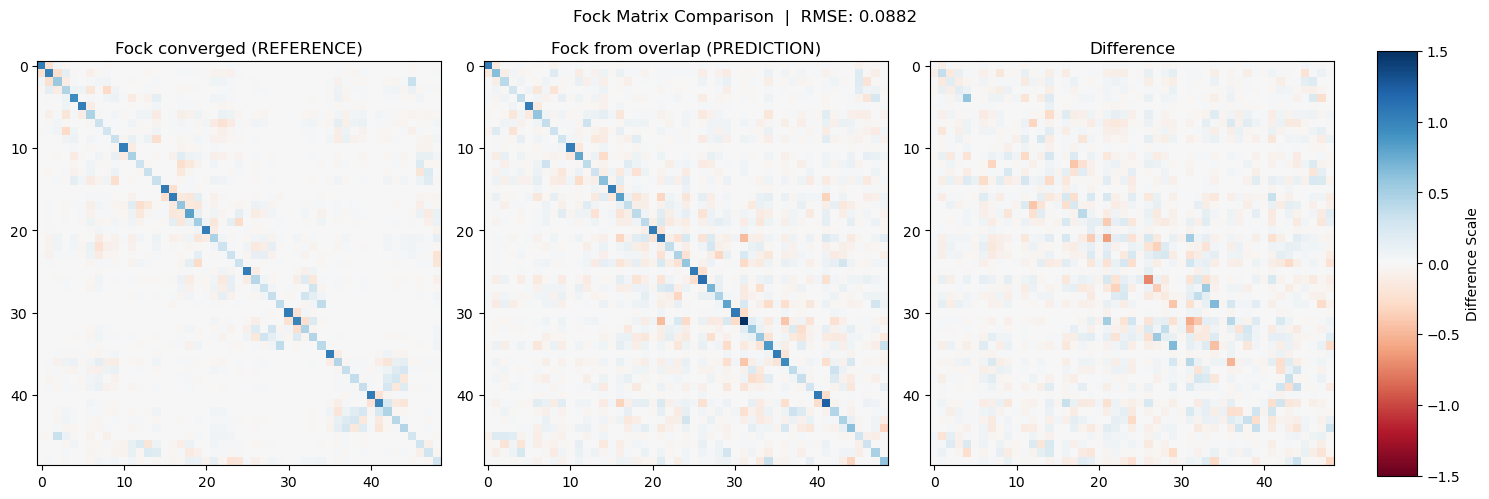

In [ ]:
plot_fock_comparison(ref_density, guess_density, 49, matrix_metric="Denstiy", title="Density Matrix Comparison", vmax=1.5)